In [1]:
import pandas as pd
import re
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearnex import patch_sklearn
patch_sklearn()

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
# Load the dataset files 
customer_df = pd.read_csv('customer.csv')

In [3]:
# Remove duplicate
df = customer_df[['emp_title']].drop_duplicates()

In [4]:
# Clean and standardize job titles
df['clean_title'] = df['emp_title'].fillna('')
df['clean_title'] = df['clean_title'].str.lower().str.strip()

In [5]:
# Remove meaningless entries
df.loc[df['clean_title'].isin(['', 'n/a', 'unknown', 'none']), 'clean_title'] = ''

In [6]:
df

,emp_title,clean_title
0,NaN,
2,Care Giver,care giver
74,Nurse Practitioner,nurse practitioner
354,Licensed,licensed
837,Manager,manager
...,...,...
270281,hazmat,hazmat
270283,Sr. Puser,sr. puser
270288,Sr. Purser,sr. purser
270295,Assistant attorney general,assistant attorney general


In [7]:
# Define level-related keywords and patterns for job level extraction
level_keywords = {
    'ceo': 6, 'chief executive officer': 6, 'president': 6, 'founder': 6, 'owner': 6, 
    'chief executive':6, 'cfo': 6, 'chief financial officer': 6, 'coo': 6,  'c-suite': 6,
    'chief operating officer': 6, 'cto': 6, 'chief technology officer': 6, 'chief': 6, 
    
    'evp': 5, 'executive vice president': 5, 'director': 5, 'vp': 5, 'v.p': 5, 'v. p': 5,
    'vise president': 5, 'vice president': 5, 'avp': 5, 'assistant vice president': 5, 
    'svp': 5, 'senior vice president': 5,

    'manager': 4, 'mgr': 4, 'head of': 4, 'head': 4, 'managing': 4, 'principal': 4,
    
    'team lead': 3, 'lead': 3, 'leadership': 3, 'senior': 3, 'sr.': 3, 'sr ': 3, ' sr': 3, 
    
    'supervisor': 2, 'subject matter expert': 2, 'sme': 2, 'executive': 2, 'consultant': 2,
    'specialist': 2, 'expert': 2, 'advanced': 2,
    
    'junior': 1, 'jr': 1, 'jr.': 1, 'entry': 1, 'trainee': 1, 'intern': 1, 
    'assistant': 1, 'associate': 1, 'apprentice': 1, 'asso': 1, 'assis': 1
}

In [8]:
# Regex patterns for job level extraction
patterns = [
    (r'\b(c[efoxits]o)\b', 'C-level'),  # Match all C-suite titles
    (r'\b(svp|evp)\b', 'Director-level'),      # Senior/Executive VP
    (r'\b(avp)\b', 'Director-level'),           # Assistant VP
    (r'\b(vp|v\.p\.)\b', 'Director-level'),     # VP variations
    (r'\b(sr|senior)\s+manager\b', 'Management'),
    (r'\b(sr|senior)\s+(staff|engineer|developer|analyst)\b', 'Mid-level'),
    (r'\b(jr|junior)\s+', 'Entry Level'),
    (r'\bassociate\b', 'Entry Level'),
    (r'\bassistant\s+manager\b', 'Management')  # Assistant Manager is still a manager
]

In [9]:
# Extract job levels
df['job_level'] = np.nan

for idx, row in df.iterrows():
    title = row['clean_title']
    
    if title == '':
        df.at[idx, 'job_level'] = np.nan
        continue
    
    # Check for patterns first
    pattern_matched = False
    for pattern, level in patterns:
        if re.search(pattern, title):
            df.at[idx, 'job_level'] = level
            pattern_matched = True
            break
    
    if pattern_matched:
        continue
    
    # Then check for keywords, taking the highest priority
    max_priority = 0
    job_level = None
    
    for keyword, priority in level_keywords.items():
        # Match whole words only
        if re.search(r'\b' + re.escape(keyword) + r'\b', title) and priority > max_priority:
            max_priority = priority
            if priority > 5:
                job_level = 'C-level'
            elif priority == 5:
                job_level = 'Director-level'
            elif priority == 4:
                job_level = 'Management'
            elif priority == 3:
                job_level = 'Mid-level'
            elif priority == 2:
                job_level = 'Individual Contributor'
            elif priority == 1:
                job_level = 'Entry Level'
    
    # If no match is found, set to 'staff'
    df.at[idx, 'job_level'] = job_level if job_level else 'Entry Level'

In [18]:
# df[['emp_title', 'job_level']].to_excel("level.xlsx", index=False)

In [10]:
df['job_level'].value_counts()

job_level
Entry Level               58536
Management                10280
Individual Contributor     7722
Mid-level                  5166
Director-level             5155
C-level                    2071
Name: count, dtype: int64

In [11]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [12]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
tqdm.pandas(disable=True)

In [13]:
# Disable progress bar widget to avoid the display error
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

In [14]:
embeddings = model.encode(df['clean_title'].astype(str).tolist(), show_progress_bar=False)

In [15]:
embeddings.shape

(88933, 384)

In [27]:
k_range = range(10, 100, 10)
inertias = []
k_values_tested = []

print(f"Testing K values in range: {list(k_range)}")

for k_test in k_range:
    if k_test == 0: continue # Skip k=0
    if k_test >= embeddings.shape[0]: # Cannot have more clusters than samples
        print(f"Skipping k_test={k_test} as it's >= number of samples ({embeddings.shape[0]})")
        break
    print(f"  Testing k={k_test}...")
    mbk_elbow = KMeans(n_clusters=k_test,
                        random_state=42,
                        n_init=10, # Fewer inits for speed during elbow search
                        )
    mbk_elbow.fit(embeddings)
    inertias.append(mbk_elbow.inertia_)
    k_values_tested.append(k_test)

Testing K values in range: [10, 20, 30, 40, 50, 60, 70, 80, 90]
  Testing k=10...
  Testing k=20...
  Testing k=30...
  Testing k=40...
  Testing k=50...
  Testing k=60...
  Testing k=70...
  Testing k=80...
  Testing k=90...


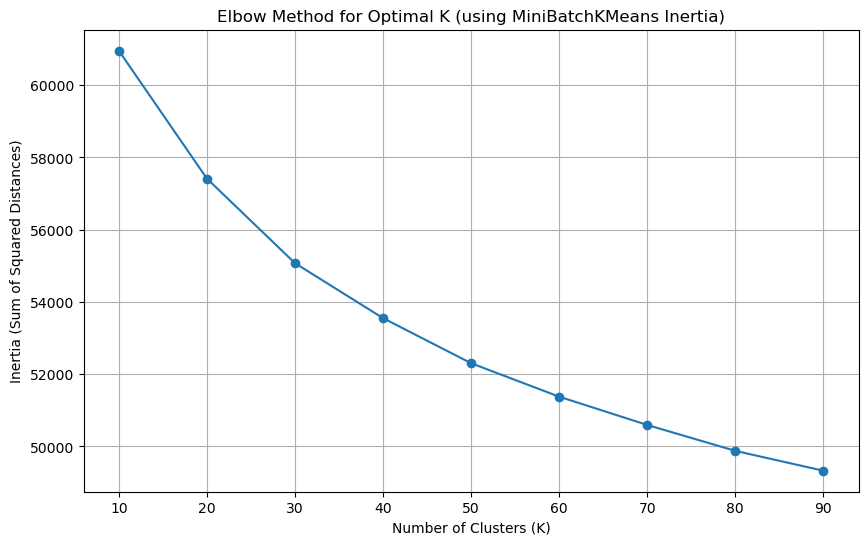

In [ ]:
import matplotlib.pyplot as plt
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values_tested, inertias, marker='o')
plt.title('Elbow Method for Optimal K (using MiniBatchKMeans Inertia)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(k_values_tested)
plt.grid(True)
plt.show()

In [29]:
try:
    from kneed import KneeLocator
    kneed_available = True
except ImportError:
    kneed_available = False
    print("kneed library not found. Install with 'pip install kneed' for automatic elbow detection.")

Optimal K suggested by KneeLocator: 40


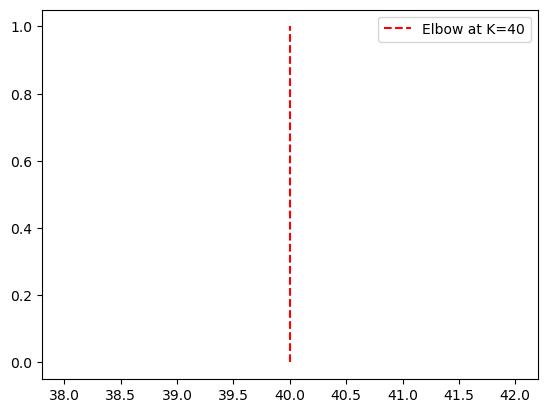

In [30]:
chosen_k = None
if kneed_available and k_values_tested and inertias: # Check if kneed is available and data exists
    try:
        kl = KneeLocator(k_values_tested, inertias, curve='convex', direction='decreasing')
        chosen_k = kl.elbow
        if chosen_k:
            print(f"Optimal K suggested by KneeLocator: {chosen_k}")
            plt.vlines(chosen_k, plt.ylim()[0], plt.ylim()[1], linestyles='--', color='r', label=f'Elbow at K={chosen_k}')
            plt.legend()
            plt.show() # Show plot again with the detected elbow
        else:
            print("KneeLocator could not find an elbow. Please choose K manually from the plot.")
    except Exception as e:
        print(f"Error using KneeLocator: {e}. Please choose K manually.")

Optimal K: 40

In [17]:
# Set number of clusters
n_clusters = 40

In [18]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)
df['job_cluster'] = kmeans.labels_

In [19]:
df['job_cluster'].value_counts()

job_cluster
0     5992
5     4328
17    4164
27    3918
20    3649
26    3371
28    3141
9     2933
10    2650
7     2646
30    2617
11    2460
6     2429
32    2378
24    2356
23    2355
18    2237
36    2195
2     2192
8     2146
1     2010
34    1996
25    1972
38    1951
19    1818
33    1807
29    1761
4     1747
21    1577
39    1521
13    1417
31    1370
37    1369
35    1340
16    1056
15     955
22     953
3      776
14     712
12     668
Name: count, dtype: int64

In [20]:
for i in sorted(df['job_cluster'].unique()):
    print(f"\n--- Cluster {i} ---")
    print(df[df['job_cluster'] == i]['clean_title'].value_counts().head(20))


--- Cluster 0 ---
clean_title
lpn                7
rn                 7
lvn                6
fire fighter       6
conductor          6
sanitation         6
server             6
receiving          6
parts              5
gm                 5
cocktail server    5
hha                5
svp                5
hairstylist        5
collector          5
cota               5
superintendant     5
forman             5
dietary            5
partner            5
Name: count, dtype: int64

--- Cluster 1 ---
clean_title
customer service                   10
customer service representative    10
customer service agent              9
service manager                     9
service director                    8
customer service manager            7
food service                        7
customer service specialist         7
service advisor                     7
customer service rep                7
environmental services              6
customer relations                  6
customer service associate          

In [21]:
cluster_to_profession = {
    0: "Others",
    1: "Admin/Assistant/Support/Services",
    2: "IT/Technician/Engineer",
    3: "Security",
    4: "Logistics/Delivery/Driver",
    5: "IT/Technician/Engineer",
    6: "Agent/Legal/Insuarance",
    7: "Convenience Services",
    8: "Educator/Teaching",
    9: "Specialist",
    10: "Manager",
    11: "Management/Specialist/Supervisor",
    12: "Manager",
    13: "Admin/Assistant/Support/Services",
    14: "Financial/Accounting/Analyst",
    15: "Clerk",
    16: "Counselor/Therapist",
    17: "Production/Assembler",
    18: "Senior",
    19: "Worker",
    20: "Management/Specialist/Supervisor",
    21: "Consultant",
    22: "Educator/Teaching",
    23: "Manufacture/Distributor",
    24: "Admin/Assistant/Support/Services",
    25: "Leader",
    26: "Director",
    27: "Foreman/Journeyman",
    28: "Healthcare/Medical",
    29: "Financial/Accounting/Analyst",
    30: "Civil Servant",
    31: "Vice President",
    32: "Sales/Marketing",
    33: "Senior",
    34: "Financial/Accounting/Analyst",
    35: "Healthcare/Medical",
    36: "Operations",
    37: "Mechanic/Maintenance",
    38: "Coordinator",
    39: "Financial/Accounting/Analyst"
}

In [22]:
df['profession'] = df['job_cluster'].map(cluster_to_profession)

Cluster lại 1 số cụm

In [24]:
clusters_to_filter = [0, 7, 9, 10, 12, 18, 25, 26, 27, 31, 33, 36]

In [25]:
df2 = df[df['job_cluster'].isin(clusters_to_filter)][['emp_title']]
df2.reset_index(drop=True)

,emp_title
0,NaN
1,LPN
2,Groundskeeper
3,Driver
4,EMT
...,...
31754,Captain EMT-A
31755,hazmat
31756,Sr. Puser
31757,Sr. Purser


In [26]:
# Clean and standardize job titles
df2['clean_title'] = df2['emp_title'].fillna('')
df2['clean_title'] = df2['clean_title'].str.lower().str.strip()

In [27]:
# Remove meaningless entries
df2.loc[df['clean_title'].isin(['', 'n/a', 'unknown', 'none']), 'clean_title'] = ''

Remove all level-related keywords before clustering

In [28]:
all_level_terms = list(level_keywords.keys())

In [29]:
# Add additional level terms and variations
additional_level_terms = ['senior', 'sr', 'sr.', 'junior', 'jr', 'jr.', 
                          'manager', 'director', 'vp', 'avp', 'svp', 'evp',
                          'chief', 'ceo', 'cfo', 'cto', 'coo', 'executive',
                          'vice president', 'assistant', 'associate', 'lead',
                          'head', 'principal', 'supervisor']
all_level_terms.extend(additional_level_terms)

In [30]:
# Remove duplicates
all_level_terms = list(set(all_level_terms))

In [31]:
# Create regex pattern for all level terms (ensure whole word matches)
level_pattern = r'\b(' + '|'.join(all_level_terms) + r')\b'

In [32]:
# Create a clean version of titles with level-related keywords removed for clustering
df2['clustering_title'] = df2['clean_title'].copy()

In [33]:
# Remove level terms
df2['clustering_title'] = df2['clustering_title'].str.replace(level_pattern, '', regex=True)
# Clean up multiple spaces
df2['clustering_title'] = df2['clustering_title'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [34]:
df2

,emp_title,clean_title,clustering_title
0,NaN,,
877,LPN,lpn,lpn
1222,Groundskeeper,groundskeeper,groundskeeper
1328,Driver,driver,driver
1704,EMT,emt,emt
...,...,...,...
270256,Captain EMT-A,captain emt-a,captain emt-a
270281,hazmat,hazmat,hazmat
270283,Sr. Puser,sr. puser,. puser
270288,Sr. Purser,sr. purser,. purser


In [35]:
embeddings2 = model.encode(df2['clustering_title'].astype(str).tolist(), show_progress_bar=False)

In [99]:
k_range = range(10, 60, 10)
inertias = []
k_values_tested = []

print(f"Testing K values in range: {list(k_range)}")

for k_test in k_range:
    if k_test == 0: continue # Skip k=0
    if k_test >= embeddings2.shape[0]: # Cannot have more clusters than samples
        print(f"Skipping k_test={k_test} as it's >= number of samples ({embeddings2.shape[0]})")
        break
    print(f"  Testing k={k_test}...")
    mbk_elbow = KMeans(n_clusters=k_test,
                        random_state=42,
                        n_init=10, # Fewer inits for speed during elbow search
                        )
    mbk_elbow.fit(embeddings2)
    inertias.append(mbk_elbow.inertia_)
    k_values_tested.append(k_test)

Testing K values in range: [10, 20, 30, 40, 50]
  Testing k=10...
  Testing k=20...
  Testing k=30...
  Testing k=40...
  Testing k=50...


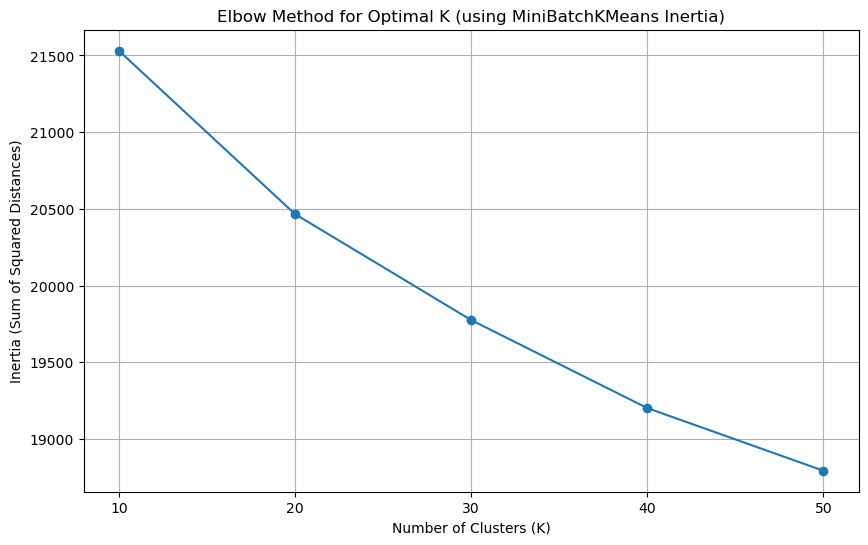

In [100]:
import matplotlib.pyplot as plt
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values_tested, inertias, marker='o')
plt.title('Elbow Method for Optimal K (using MiniBatchKMeans Inertia)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(k_values_tested)
plt.grid(True)
plt.show()

In [101]:
chosen_k = None
if kneed_available and k_values_tested and inertias: # Check if kneed is available and data exists
    try:
        kl = KneeLocator(k_values_tested, inertias, curve='convex', direction='decreasing')
        chosen_k = kl.elbow
        if chosen_k:
            print(f"Optimal K suggested by KneeLocator: {chosen_k}")
            plt.vlines(chosen_k, plt.ylim()[0], plt.ylim()[1], linestyles='--', color='r', label=f'Elbow at K={chosen_k}')
            plt.legend()
            plt.show() # Show plot again with the detected elbow
        else:
            print("KneeLocator could not find an elbow. Please choose K manually from the plot.")
    except Exception as e:
        print(f"Error using KneeLocator: {e}. Please choose K manually.")


KneeLocator could not find an elbow. Please choose K manually from the plot.


In [36]:
# Set number of clusters
n_clusters = 40

In [37]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings2)
df2['job_cluster_2'] = kmeans.labels_

In [38]:
df2

,emp_title,clean_title,clustering_title,job_cluster_2
0,NaN,,,9
877,LPN,lpn,lpn,19
1222,Groundskeeper,groundskeeper,groundskeeper,38
1328,Driver,driver,driver,33
1704,EMT,emt,emt,28
...,...,...,...,...
270256,Captain EMT-A,captain emt-a,captain emt-a,14
270281,hazmat,hazmat,hazmat,34
270283,Sr. Puser,sr. puser,. puser,4
270288,Sr. Purser,sr. purser,. purser,35


In [39]:
df2['job_cluster_2'].value_counts()

job_cluster_2
34    2415
18    1989
16    1980
4     1827
38    1488
3     1425
36    1279
26    1172
19    1111
22    1103
13     889
35     882
7      840
11     759
37     748
12     727
30     712
25     676
15     644
23     642
17     637
24     577
32     559
9      510
1      501
2      483
39     468
33     466
31     465
0      461
8      460
5      459
6      399
28     382
20     376
14     328
29     319
27     294
10     191
21     116
Name: count, dtype: int64

In [41]:
for i in sorted(df2['job_cluster_2'].unique()):
    print(f"\n--- Cluster {i} ---")
    print(df2[df2['job_cluster_2'] == i]['clean_title'].value_counts().head(20))


--- Cluster 0 ---
clean_title
truck driver                  12
forklift driver                9
tractor trailer driver         8
bus driver                     8
otr truck driver               7
package car driver             7
transport driver               6
shuttle driver                 6
professional truck driver      5
line haul driver               5
over the road truck driver     5
motor vehicle operator         5
road driver                    5
taxi driver                    5
truck  driver                  4
tanker driver                  4
truck drive                    4
commercial truck driver        4
yard driver                    4
uber driver                    4
Name: count, dtype: int64

--- Cluster 1 ---
clean_title
director of business development        7
senior software developer               6
product development manager             5
director of development                 4
vp business development                 4
senior web developer                    4


In [145]:
cluster_to_profession2 = {
    0: "Logistics/Delivery/Driver",
    1: "Management/Specialist/Supervisor",
    2: "Operations",
    3: "Management/Specialist/Supervisor",
    4: "IT/Technician/Engineer",
    5: "Production/Assembler",
    6: "Representative/Relations",
    7: "Healthcare/Medical",
    8: "IT/Technician/Engineer",
    9: "Others",
    10: "Management/Specialist/Supervisor",
    11: "Food and Beverage",
    12: "Management/Specialist/Supervisor",
    13: "Others",
    14: "Management/Specialist/Supervisor",
    15: "Others",
    16: "Sales/Marketing",
    17: "Human Resources",
    18: "Sales/Marketing",
    19: "Others",
    20: "IT/Technician/Engineer",
    21: "Others",
    22: "Others",
    23: "Operations",
    24: "Operations",
    25: "Convenience Services",
    26: "Operations",
    27: "Logistics/Delivery/Driver",
    28: "Others",
    29: "Management/Specialist/Supervisor",
    30: "Management/Specialist/Supervisor",
    31: "Admin/Assistant/Support/Services",
    32: "IT/Technician/Engineer",
    33: "Others",
    34: "Logistics/Delivery/Driver",
    35: "Management/Specialist/Supervisor",
    36: "Financial/Accounting/Analyst",
    37: "Others",
    38: "Others",
    39: "IT/Technician/Engineer"
}

In [147]:
df2['profession2'] = df2['job_cluster_2'].map(cluster_to_profession2)

In [149]:
df2['profession2'].value_counts()

profession2
Others                              12866
Management/Specialist/Supervisor     5807
IT/Technician/Engineer               3343
Operations                           2268
Logistics/Delivery/Driver            1724
Convenience Services                 1241
Sales/Marketing                       766
Admin/Assistant/Support/Services      733
Financial/Accounting/Analyst          685
Food and Beverage                     682
Production/Assembler                  676
Healthcare/Medical                    513
Human Resources                       288
Representative/Relations              167
Name: count, dtype: int64

In [151]:
df2

,emp_title,clean_title,clustering_title,job_cluster_2,profession2
0,NaN,,,29,Management/Specialist/Supervisor
877,LPN,lpn,lpn,37,Others
1222,Groundskeeper,groundskeeper,groundskeeper,19,Others
1328,Driver,driver,driver,34,Logistics/Delivery/Driver
1704,EMT,emt,emt,38,Others
...,...,...,...,...,...
270256,Captain EMT-A,captain emt-a,captain emt-a,13,Others
270281,hazmat,hazmat,hazmat,38,Others
270283,Sr. Puser,sr. puser,. puser,28,Others
270288,Sr. Purser,sr. purser,. purser,19,Others


In [181]:
df = pd.merge(df, df2[['emp_title', 'profession2']], on='emp_title', how='left')

In [182]:
df

,emp_title,clean_title,job_level,job_cluster,profession,profession2
0,NaN,,NaN,0,Others,Management/Specialist/Supervisor
1,Care Giver,care giver,Entry Level,28,Healthcare/Medical,NaN
2,Nurse Practitioner,nurse practitioner,Entry Level,35,Healthcare/Medical,NaN
3,Licensed,licensed,Entry Level,23,Manufacture/Distributor,NaN
4,Manager,manager,Management,20,Management/Specialist/Supervisor,NaN
...,...,...,...,...,...,...
88928,hazmat,hazmat,Entry Level,0,Others,Others
88929,Sr. Puser,sr. puser,Entry Level,0,Others,Others
88930,Sr. Purser,sr. purser,Entry Level,27,Foreman/Journeyman,Others
88931,Assistant attorney general,assistant attorney general,Entry Level,24,Admin/Assistant/Support/Services,NaN


In [192]:
df['profession3'] = np.where(
    df['clean_title'].isin(['', 'n/a', 'unknown', 'none']),
    'No Information',
    np.where(
        df['profession2'].isna(),
        df['profession'],
        df['profession2']
    )
)

In [193]:
df['profession3'].value_counts()

profession3
Others                              12866
Management/Specialist/Supervisor    11915
IT/Technician/Engineer               9863
Financial/Accounting/Analyst         6675
Admin/Assistant/Support/Services     6516
Healthcare/Medical                   4994
Production/Assembler                 4840
Logistics/Delivery/Driver            3471
Sales/Marketing                      3144
Educator/Teaching                    3099
Civil Servant                        2617
Agent/Legal/Insuarance               2429
Manufacture/Distributor              2355
Operations                           2268
Coordinator                          1951
Worker                               1818
Consultant                           1577
Mechanic/Maintenance                 1369
Convenience Services                 1241
Counselor/Therapist                  1056
Clerk                                 955
Security                              776
Food and Beverage                     682
Human Resources       

In [194]:
df

,emp_title,clean_title,job_level,job_cluster,profession,profession2,profession3
0,NaN,,NaN,0,Others,Management/Specialist/Supervisor,No Information
1,Care Giver,care giver,Entry Level,28,Healthcare/Medical,NaN,Healthcare/Medical
2,Nurse Practitioner,nurse practitioner,Entry Level,35,Healthcare/Medical,NaN,Healthcare/Medical
3,Licensed,licensed,Entry Level,23,Manufacture/Distributor,NaN,Manufacture/Distributor
4,Manager,manager,Management,20,Management/Specialist/Supervisor,NaN,Management/Specialist/Supervisor
...,...,...,...,...,...,...,...
88928,hazmat,hazmat,Entry Level,0,Others,Others,Others
88929,Sr. Puser,sr. puser,Entry Level,0,Others,Others,Others
88930,Sr. Purser,sr. purser,Entry Level,27,Foreman/Journeyman,Others,Others
88931,Assistant attorney general,assistant attorney general,Entry Level,24,Admin/Assistant/Support/Services,NaN,Admin/Assistant/Support/Services


In [197]:
customer_df = pd.merge(customer_df, df[['emp_title','job_level', 'profession3']], on='emp_title', how='left')

In [199]:
customer_df['profession3'].value_counts()

profession3
Management/Specialist/Supervisor    47967
Others                              26438
IT/Technician/Engineer              25828
No Information                      23662
Financial/Accounting/Analyst        18080
Admin/Assistant/Support/Services    17964
Healthcare/Medical                  13828
Educator/Teaching                   12425
Logistics/Delivery/Driver           11296
Sales/Marketing                     11122
Production/Assembler                 9379
Civil Servant                        8920
Operations                           6891
Worker                               6450
Agent/Legal/Insuarance               5753
Mechanic/Maintenance                 3730
Coordinator                          3707
Consultant                           3093
Manufacture/Distributor              3041
Counselor/Therapist                  2651
Clerk                                2147
Food and Beverage                    1841
Security                             1758
Convenience Services  

In [200]:
df

,emp_title,clean_title,job_level,job_cluster,profession,profession2,profession3
0,NaN,,NaN,0,Others,Management/Specialist/Supervisor,No Information
1,Care Giver,care giver,Entry Level,28,Healthcare/Medical,NaN,Healthcare/Medical
2,Nurse Practitioner,nurse practitioner,Entry Level,35,Healthcare/Medical,NaN,Healthcare/Medical
3,Licensed,licensed,Entry Level,23,Manufacture/Distributor,NaN,Manufacture/Distributor
4,Manager,manager,Management,20,Management/Specialist/Supervisor,NaN,Management/Specialist/Supervisor
...,...,...,...,...,...,...,...
88928,hazmat,hazmat,Entry Level,0,Others,Others,Others
88929,Sr. Puser,sr. puser,Entry Level,0,Others,Others,Others
88930,Sr. Purser,sr. purser,Entry Level,27,Foreman/Journeyman,Others,Others
88931,Assistant attorney general,assistant attorney general,Entry Level,24,Admin/Assistant/Support/Services,NaN,Admin/Assistant/Support/Services


In [201]:
job = df[['emp_title','job_level', 'profession3']]

In [205]:
job = job.rename(columns = {'profession3':'profession'})

In [206]:
job['job_level'] = np.where(
    job['job_level'].isna() | (job['job_level'] == ''),
    'No Information',
    job['job_level']
)

In [207]:
job['job_level'].value_counts()

job_level
Entry Level               58536
Management                10280
Individual Contributor     7722
Mid-level                  5166
Director-level             5155
C-level                    2071
No Information                3
Name: count, dtype: int64

In [204]:
job.to_excel('job_mapping.xlsx', index=False)